Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        1088      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 instance_normalization_2 (I  (None, 8, 8, 128)        2         
 nstanceNormalization)                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 256)         524544    
                                                      

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\shrir\\OneDrive\\Desktop\\GAN\\GAN_PS\\CCGAN\\images\\0.png'

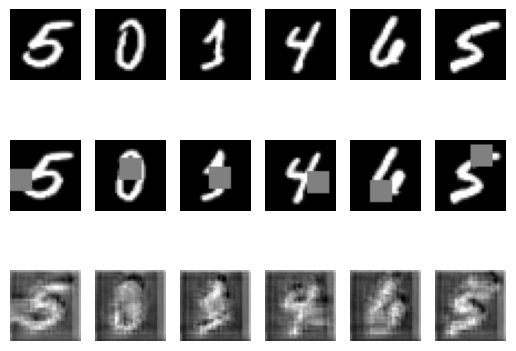

In [5]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import scipy
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

class CCGAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.mask_height = 10
        self.mask_width = 10
        self.num_classes = 10

        # Number of filters in first layer of generator and discriminator
        self.gf = 32
        self.df = 32

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['mse', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        masked_img = Input(shape=self.img_shape)
        gen_img = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(gen_img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(masked_img , valid)
        self.combined.compile(loss=['mse'],
            optimizer=optimizer)


    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(img, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(img, output_img)

    def build_discriminator(self):

        img = Input(shape=self.img_shape)

        model = Sequential()
        model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.8))
        model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(InstanceNormalization())
        model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(InstanceNormalization())

        model.summary()

        img = Input(shape=self.img_shape)
        features = model(img)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(features)

        label = Flatten()(features)
        label = Dense(self.num_classes+1, activation="softmax")(label)

        return Model(img, [validity, label])

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs


    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale MNIST to 32x32
        from PIL import Image

        X_train = np.array([np.array(Image.fromarray(x).resize((self.img_cols, self.img_rows))) for x in X_train])


        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 4, 4, 1))
        fake = np.zeros((batch_size, 4, 4, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Sample half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            labels = y_train[idx]

            masked_imgs = self.mask_randomly(imgs)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(masked_imgs)

            # One-hot encoding of labels
            labels = to_categorical(labels, num_classes=self.num_classes+1)
            fake_labels = to_categorical(np.full((batch_size, 1), self.num_classes), num_classes=self.num_classes+1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch(masked_imgs, valid)

            # Plot the progress
            print ("%d [D loss: %f, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[4], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
                self.save_model()

    def sample_images(self, epoch, imgs):
        r, c = 3, 6

        masked_imgs = self.mask_randomly(imgs)
        gen_imgs = self.generator.predict(masked_imgs)

        imgs = (imgs + 1.0) * 0.5
        masked_imgs = (masked_imgs + 1.0) * 0.5
        gen_imgs = (gen_imgs + 1.0) * 0.5

        gen_imgs = np.where(gen_imgs < 0, 0, gen_imgs)

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :, :, 0], cmap='gray')
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :, :, 0], cmap='gray')
            axs[1,i].axis('off')
            axs[2,i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
            axs[2,i].axis('off')
        fig.savefig("images/%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "ccgan_generator")
        save(self.discriminator, "ccgan_discriminator")


if __name__ == '__main__':
    ccgan = CCGAN()
    ccgan.train(epochs=20000, batch_size=32, sample_interval=200)